## Subgraph sampling using k-path motif sampling

In [3]:
#Imports
import numpy as np
from NNetwork import NNetwork as nn
import networkx as nx
#import utils.NNetwork as nn
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import metrics, model_selection
from tqdm import trange
from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA ### Use truncated SVD / online PCA later for better computational efficiency 

In [4]:
def display_graphs(title,
                     save_path,
                     grid_shape=[2,3],
                     fig_size=[10,10],
                     data = None, # [X, embs]
                     show_importance=False):

        # columns of X = vectorized k x k adjacency matrices
        # corresponding list in embs = sequence of nodes (may overalp)
        X, embs = data
        print('X.shape', X.shape)

        rows = grid_shape[0]
        cols = grid_shape[1]

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        # make outer gridspec

        idx = np.arange(X.shape[1])
        outer_grid = gridspec.GridSpec(nrows=rows, ncols=cols, wspace=0.02, hspace=0.02)

        # make nested gridspecs
        for i in range(rows * cols):
            a = i // cols
            b = i % rows

            Ndict_wspace = 0.05
            Ndict_hspace = 0.05

            # display graphs
            inner_grid = outer_grid[i].subgridspec(1, 1, wspace=Ndict_wspace, hspace=Ndict_hspace)

            # get rid of duplicate nodes
            A = X[:,idx[i]]
            A = X[:,idx[i]].reshape(int(np.sqrt(X.shape[0])), -1)
            H = nn.NNetwork()
            H.read_adj(A, embs[idx[i]])
            A_sub = H.get_adjacency_matrix()

            # read in as a nx graph for plotting
            G1 = nx.from_numpy_matrix(A_sub)
            ax = fig.add_subplot(inner_grid[0, 0])
            pos = nx.spring_layout(G1)
            edges = G1.edges()
            weights = [1*G1[u][v]['weight'] for u,v in edges]
            nx.draw(G1, with_labels=False, node_size=20, ax=ax, width=weights, label='Graph')

            ax.set_xticks([])
            ax.set_yticks([])

        plt.suptitle(title, fontsize=15)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')

In [5]:
def display_dict_and_graph(title,
                           W, 
                           singular_values, 
                           save_path,
                           grid_shape=None,
                           fig_size=[10,10],
                           show_importance=False,
                           only_show_matrices=True):
        
        n_components = W.shape[1]
        k = int(np.sqrt(W.shape[0]))

        rows = np.round(np.sqrt(n_components))
        rows = rows.astype(int)
        if grid_shape is not None:
            rows = grid_shape[0]
            cols = grid_shape[1]
        else:
            if rows ** 2 == n_components:
                cols = rows
            else:
                cols = rows + 1

        if show_importance:
            # importance = np.sum(self.code, axis=1) / sum(sum(self.code))
            idx = np.argsort(singular_values)
            idx = np.flip(idx)
        else:
            idx = np.arange(W.shape[1])

        Ndict_wspace = 0.05
        Ndict_hspace = 0.05

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        ncols = 2 
        if only_show_matrices:
            ncols = 1
        outer_grid = gridspec.GridSpec(nrows=1, ncols=ncols, wspace=0.02, hspace=0.02)
        for t in np.arange(2):
            # make nested gridspecs

            if t == 0:
                ### Make gridspec
                inner_grid = outer_grid[t].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols
                    ax = fig.add_subplot(inner_grid[a, b])
                    ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
                    # ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                    # ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches
                    ax.set_xticks([])
                    ax.set_yticks([])
            if (t == 1) and not only_show_matrices:
                inner_grid = outer_grid[t].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)

                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols

                    G1 = nx.from_numpy_matrix(W[:,idx[i]].reshape(int(np.sqrt(W.shape[0])),-1))
                    ax = fig.add_subplot(inner_grid[a, b])
                    pos = nx.spring_layout(G1)
                    edges = G1.edges()
                    weights = [2*G1[u][v]['weight'] for u,v in edges]
                    nx.draw(G1, with_labels=False, node_size=10, ax=ax, width=weights, label='Graph')
                    if show_importance:
                        ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                        ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches

                    ax.set_xticks([])
                    ax.set_yticks([])

        if title is not None:
            plt.suptitle(title, fontsize=25)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')

In [9]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'Subgraph_sampling/test1/'
k=20

path = "Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

#mx0 = G.get_adjacency_matrix(ordered_node_list=G.nodes())
#plt.imshow(mx0)

num nodes in G 769
num edges in G 33312


num of subgraphs induced on k-paths: 10000
X.shape (400, 10000)


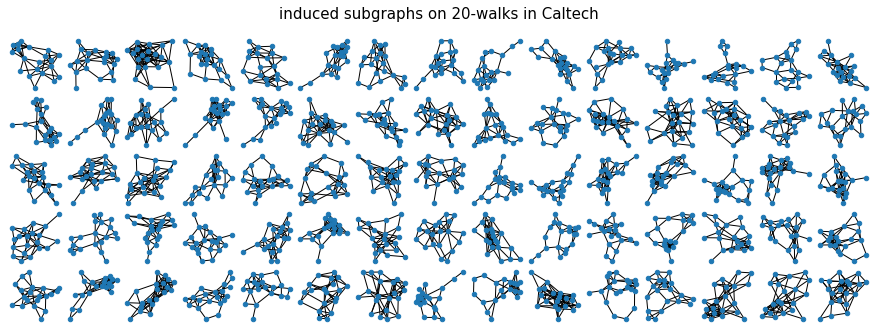

In [10]:
X, embs = G.get_patches(k=k, sample_size=10000, skip_folded_hom=True)

display_graphs(title='induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

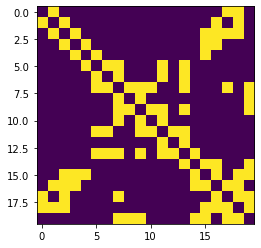

In [11]:
plt.imshow(X[:,4].reshape(k,k))